In [1]:
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.style.use('seaborn-darkgrid')
# Change the font ?
font = {'size'   : 15}
plt.rc('font', **font)

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import os
import getpass
import pickle
import random

In [3]:
import sys

sys.path.append("../")

import allpoetry

Add your [allpoetry.com](allpoetry.com) credentials here:

In [4]:
username = getpass.getpass("Enter your username: ")
password = getpass.getpass("Enter your password: ")

api = allpoetry.AllPoetry(username, password)

Enter your username:  ······
Enter your password:  ········


# Fetch a specific poem 

We can get a specific poem if we know it's URL. This will get the poem text and some metadata.

In [36]:
url = "https://allpoetry.com/poem/8498499-Mirror-by-Sylvia-Plath"
poem = api.get_poem_from_url(url)

The poem itself is saved:

In [39]:
print(poem)

Mirror
¯¯¯¯¯¯

“I am silver and exact. I have no preconceptions.
Whatever I see I swallow immediately
Just as it is, unmisted by love or dislike.
I am not cruel, only truthful
The eye of a little god, four cornered.
Most of the time I meditate on the opposite wall.
It is pink, with speckles. I have looked at it so long
I think it is part of my heart. But it flickers.
Faces and darkness separate us over and over.

Now I am a lake. A woman bends over me,
Searching my reaches for what she really is.
Then she turns to those liars, the candles or the moon.
I see her back, and reflect it faithfully.
She rewards me with tears and an agitation of hands.
I am important to her. She comes and goes.
Each morning it is her face that replaces the darkness.
In me she has drowned a young girl, and in me an old woman
Rises toward her day after day, like a terrible fish.”

— Sylvia Plath
  Likes: 229, Views: 355,300


In [38]:
print(poem.author)

Sylvia-Plath


# Fetch a list of poems

First, we fetch the list of poems written by the user. 

In [15]:
AUTHOR_NAME = "Sylvia_Plath"

poem_urls = api.get_poem_links(AUTHOR_NAME, top_k=10)

In [16]:
len(poem_urls)

10

Then, we can fetch the individual poems. We'll grab 10 at random from the list. 

In [18]:
selection = random.sample(list(poem_urls.keys()), 5)
poems = [api.get_poem_from_url(poem_urls[title]) for title in selection]

for poem in poems:
    print(poem)
    print()

Daddy
¯¯¯¯¯

You do not do, you do not do
Any more, black shoe
In which I have lived like a foot
For thirty years, poor and white,
Barely daring to breathe or Achoo.

Daddy, I have had to kill you.
You died before I had time
Marble heavy, a bag full of God,
Ghastly statue with one gray toe
Big as a Frisco seal

And a head in the freakish Atlantic
Where it pours bean green over blue
In the waters off the beautiful Nauset.
I used to pray to recover you.
Ach, du.

In the German tongue, in the Polish town
Scraped flat by the roller
Of wars, wars, wars.
But the name of the town is common.
My Polack friend

Says there are a dozen or two.
So I never could tell where you
Put your foot, your root,
I never could talk to you.
The tongue stuck in my jaw.

It stuck in a barb wire snare.
Ich, ich, ich, ich,
I could hardly speak.
I thought every German was you.
And the language obscene

An engine, an engine,
Chuffing me off like a Jew.
A Jew to Dachau, Auschwitz, Belsen.
I began to talk like a Jew.
I

Then, we can look at information stored with the poems:

In [19]:
for poem in poems:
    print(f"Tags: {poem.tags}, Poem length: {len(poem)}")

Tags: [], Poem length: 531
Tags: [], Poem length: 194
Tags: [], Poem length: 122
Tags: [], Poem length: 179
Tags: [], Poem length: 141


We can aggregate these results to understand what kinds of poems this author writes:

In [22]:
tag_counts = dict()
for poem in poems:
    tags = poem.tags
    if tags == []:
        tags = ['None']
    for tag in tags:
        if tag in tag_counts:
            tag_counts[tag] += 1
        else:
            tag_counts[tag] = 1

In [23]:
tag_counts

{'None': 5}

# Fetch all of a user's poems and save as pickle 

In [24]:
AUTHOR_NAME = "Sharon_Olds"

poem_urls = api.get_poem_links(AUTHOR_NAME)

In [25]:
poems, fail = dict(), dict()

for i, (title, url) in enumerate(poem_urls.items()):
    # Flush the old line
    print("\r" + " " * 500, end="")
    # Print new line
    print(f"\r{i+1:4d}/{len(poem_urls)} | {title} at {url}", end="")
    
    # Get the poems
    try:
        poem = api.get_poem_from_url(url)
        poems[title] = poem
    except IndexError as error:
        print("[ERROR] :: {error}")
        fail[title] = url

  35/35 | The Unborn at https://allpoetry.com/poem/14330815-The-Unborn-by-Sharon-Olds                                                                                                                                                                                                                                                                                                                                                                                                                               

In [26]:
fail

{}

In [27]:
with open(f"../data/{AUTHOR_NAME}.pkl", "wb") as file:
    pickle.dump(poems, file)

In [28]:
with open(f"../data/{AUTHOR_NAME}.pkl", "rb") as file:
    poems = pickle.load(file)

## Word counts and cloud 

In [29]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from collections import Counter

In [30]:
mystopwords = [",", "!", ".", ";", "-", "'", "'s", 
               "''", "...", "'re", ":", "``", "(", "?", 
               ")", "n't", "'ve", "'m", "ca", "like", "'ll", "'d", "wo", "ta"] + stopwords.words("english")

In [32]:
words = []
for _, poem in poems.items():
    words += [word.lower() for word in word_tokenize(poem.text) if word.lower() not in mystopwords]
counts = dict(Counter(words))

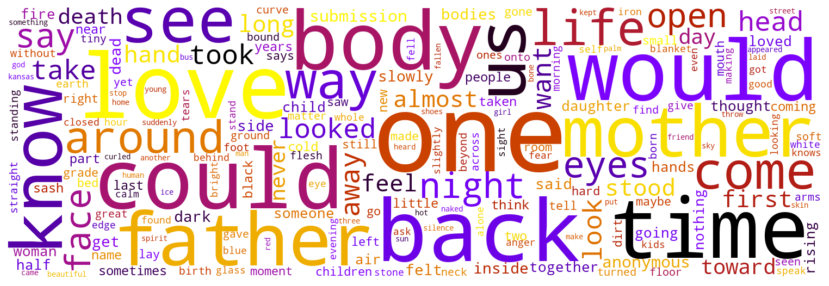

In [33]:
wordcloud = WordCloud(
    collocations=False, 
    width=1500, 
    height=500, 
    random_state=21, 
    max_font_size=200, 
    background_color="white", 
    colormap="gnuplot"
).generate_from_frequencies(counts)

fig, ax = plt.subplots(figsize=(20, 5))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()